In [97]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import logging
import os
import random
import torch
import toml
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from IPython.display import display
from typing import Tuple,List
import math

In [7]:
with open("config.toml", "r") as f:
    config = toml.load(f)

print(config['Path']['folder_path'])
print(config['Hyperparameters']['image_size'])

photos_no_class
[224, 224]


In [8]:
logger = logging.getLogger(__name__)
shell_logs = logging.StreamHandler()
file_logs = logging.FileHandler("helpers.log", mode="a", encoding="utf-8")
logger.addHandler(shell_logs)
logger.addHandler(file_logs)

In [9]:
logger.setLevel(10)

In [10]:
formatter = logging.Formatter(
    "{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
)
shell_logs.setFormatter(formatter)
file_logs.setFormatter(formatter)

shell_logs.setLevel("DEBUG")
file_logs.setLevel("INFO")

In [11]:
def Image_loader(config):
    """
    load images from source.
    Args: config(dict)
    """
    full_img_path = []
    images_list = os.listdir(config['Path']['folder_path'])
    for img in images_list:
        full_img_path.append(os.path.join(config['Path']['folder_path'], img))
        
    return full_img_path,images_list

full_img_path, images_list = Image_loader(config)

In [12]:
def image_show(config, images_list, index=None):
    """
    Show 6 random images by default or 1 image at a specific index.
    
    Args:
        config (dict): Contains keys like 'folder_path'
        images_list (list): List of image filenames (not full paths)
        index (int, optional): Index of image to display. If None, show 6 random images.
    """
    if not images_list:
        logger.debug("images_list is empty")
        return 1

    try:
        # Single indexed image
        if index is not None:
            if index < 0 or index >= len(images_list):
                logger.debug("Index out of range.")
                return

            image_name = images_list[index]
            full_path = os.path.join(config['Path']['folder_path'], image_name)
            image = Image.open(full_path)

            plt.imshow(image)
            plt.title(f"Image at index {index}:\n{full_path}")
            plt.axis('off')
            plt.show()
        
        # Show 6 random images
        else:
            num_images = min(6, len(images_list))
            sampled_images = random.sample(images_list, num_images)
            logger.info(sampled_images)
            fig, axes = plt.subplots(2, 3, figsize=(15, 8))
            axes = axes.flatten()
            
            for i, image_name in enumerate(sampled_images):
                full_path = os.path.join(config['Path']['folder_path'], image_name)
                image = Image.open(full_path)
                axes[i].imshow(image)
                axes[i].set_title(f"{image_name}", fontsize=9)
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

    except Exception as e:
        logger.error(f"Error loading image: {e}")

2025-07-29 09:46 - INFO - ['dog-g904e7432d_640.jpg', 'in-love-g33a19ee34_640.jpg', 'grandmother-g010adc60b_640.jpg', 'pasta-ge05c4d3a5_640.jpg', 'elderly-woman-gf7899b581_640.jpg', 'terrier-g5cb29fa82_640.jpg']


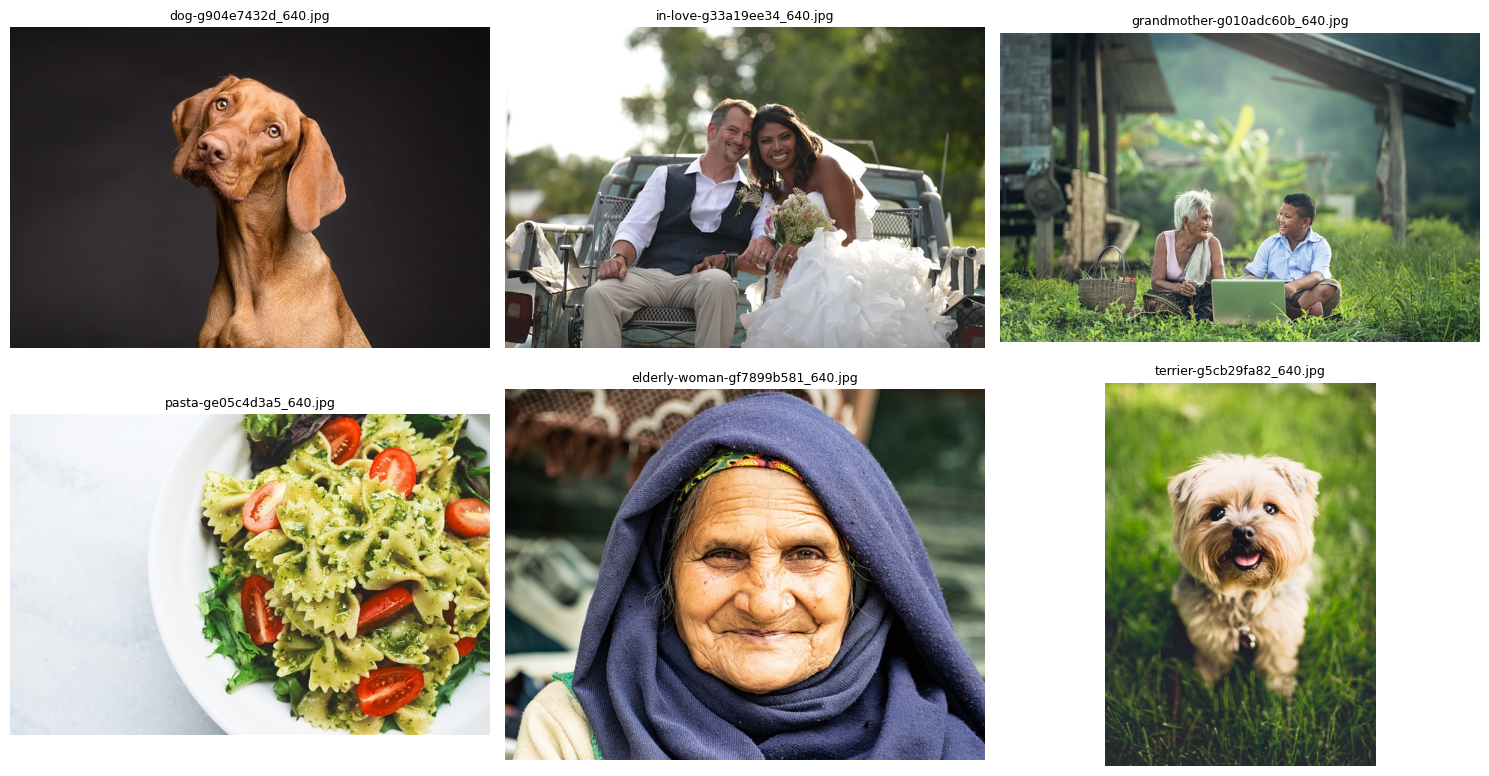

In [13]:
image_show(config, images_list)

In [14]:
def image_formatter(full_img_path, config):
    """
    format images to have same size,greyscale
    Args:
        full_img_path(List[str])
        config['Hyperparameters']['image_size']: adjust image size.
    """
 # Define transform: grayscale + resize
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize(config['Hyperparameters']['image_size']),
        transforms.ToTensor()
    ])
    
    return torch.stack([transform(Image.open(path).convert("RGB")) for path in full_img_path]) #type:ignore

In [15]:
reshaped_image_tensors = image_formatter(full_img_path, config)
reshaped_image_tensors.size()

torch.Size([80, 1, 224, 224])

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=224, scale=(0.85, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor()
])

context_block = transform(reshaped_image_tensors[0])
context_block.size()

torch.Size([1, 224, 224])

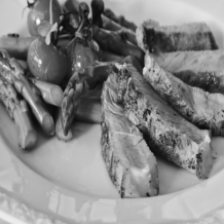

In [17]:
pil_image = F.to_pil_image(context_block[0])
display(pil_image) 

In [18]:
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        # transforms.Resize(config['Hyperparameters']['image_size']),
    ])
    
single_img = [transform(Image.open(path)) for path in full_img_path][0]

In [19]:
single_img.size

(640, 427)

In [80]:
def random_image_part_remove(image: Image.Image, scale: Tuple[float,float],aspect_ratio: Tuple[float,float]):
    """
    formats image where keeping around only some portion of image and removing some parts from it.
    Args:
        image: a PIL image
        aspect_ratio: width/height, takes in tuple of float,float where first number sets lower range of ratio, vice-versa
        scale: Area of Crop / Area of Original Image, relative size of the crop, as a proportion of the original image area.Takes in tuple of float,float
                where first number sets lower range of ratio, vice-versa.
    """

    image_array = np.transpose(np.array(image))
    height, width = image_array.shape[0], image_array.shape[1]
    random_bounded_scale = np.random.uniform(low=scale[0], high=scale[1])

    num_active_pixels_per_row = int(width * random_bounded_scale)
    num_active_pixels_per_row = max(0, min(num_active_pixels_per_row, width))

    masked_rows = []
    for _ in range(height):
        mask = np.zeros(width)
        indices = np.random.choice(width, size=num_active_pixels_per_row, replace=False)
        mask[indices] = 1
        mask = mask.reshape(1, width)
        masked_row = mask * image_array[_] # apply to the current row
        masked_rows.append(masked_row)

    masked_image = np.squeeze(np.stack(masked_rows, axis=0))
    return masked_image

In [81]:
v1_check = random_image_part_remove(single_img, (0.85,1.0), 1)
v1_check.shape

(640, 427)

In [104]:
class RandomCropsNoResize:
    """
    Randomly sample N rectangular Target crops from an image, based on scale and aspect ratio.
    """
    def __init__(self, num_crops: int = 4, scale: Tuple[float, float] = (0.15, 0.2), aspect_ratio: Tuple[float, float] = (0.75, 1.5)):
        self.num_crops = num_crops
        self.scale = scale
        self.aspect_ratio = aspect_ratio

    def __call__(self, img: Image.Image) -> List[Image.Image]:
        height, width = img.size
        area = height * width
        crops = []

        for _ in range(self.num_crops):
            for _ in range(10):  # Try 10 times to get a valid crop
                target_area = torch.empty(1).uniform_(*self.scale).item() * area
                aspect = torch.empty(1).uniform_(*self.aspect_ratio).item()

                crop_w = int(round(math.sqrt(target_area * aspect)))
                crop_h = int(round(math.sqrt(target_area / aspect)))

                if crop_w <= width and crop_h <= height:
                    top = torch.randint(0, height - crop_h + 1, (1,)).item()
                    left = torch.randint(0, width - crop_w + 1, (1,)).item()
                    crop = F.crop(img, top, left, crop_h, crop_w)
                    crops.append(crop)
                    break
                
                else:
                    # fallback center crop
                    crop_size = min(height, width)
                    top = (height - crop_size) // 2
                    left = (width - crop_size) // 2
                    crop = F.crop(img, top, left, crop_size, crop_size)
                    crops.append(crop)

        return crops

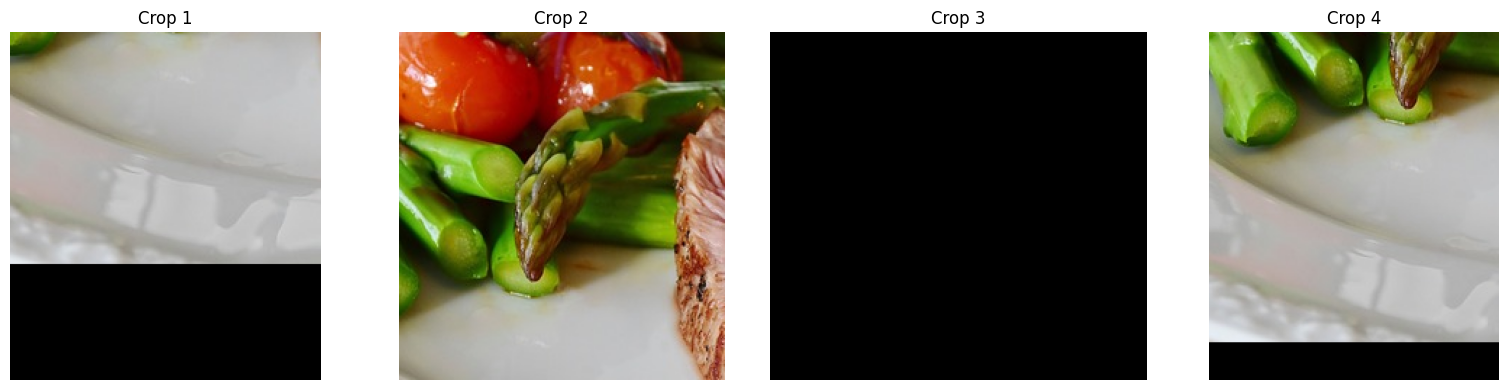

In [112]:
img = Image.open(full_img_path[0])
cropper = RandomCropsNoResize(num_crops=4, scale=(0.15, 0.2), aspect_ratio=(0.75, 1.5))
crops = cropper(img)

# Plot the 4 crops
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, crop in enumerate(crops):
    axs[i].imshow(crop)
    axs[i].axis("off")
    axs[i].set_title(f"Crop {i+1}")
plt.tight_layout()
plt.show()